In [1]:
#general
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,4)
import pandas as pd
pd.set_option('display.max_columns', 50)

#preprocessing
from datetime import datetime, timedelta
import category_encoders as ce
import mca

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense

#model validation / evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Model Evaluation Functions

In [2]:
def cm2df(cm, labels): 
    """converts a numpy array confusion matrix to a pandas dataframe, with class labels"""
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

def model_eval(y_test, y_pred): 
    """prints out a confusion matrix (pandas dataframe) and classification report"""
    conf_mat = confusion_matrix(y_test, y_pred)
    cm_as_df=cm2df(conf_mat,[0,1])
    new_names = {0:'Order Fail',1:'Order Success'}
    cm_as_df = cm_as_df.rename(index=new_names, 
                                 columns=new_names)
    print('\n')
    print('CONFUSION MATRIX (predicted along top, actual along side): ')
    display(cm_as_df)

    print('\n')
    print(classification_report(y_test,y_pred,target_names=['Order Fail','Order Success']))
    
def cross_validation(model, features, response, num_folds):
    metrics = ['precision_macro', 'recall_macro', "f1_macro"]
    cv = cross_validate(model, features, response, scoring=metrics, cv=num_folds)
    print("Test data set average precision across 5 folds:")
    print(cv['test_precision_macro'])
    print("\nTest data set average recall across 5 folds:")
    print(cv['test_recall_macro'])
    print("\nTest data set average fscore across 5 folds:")
    print(cv['test_f1_macro'])
    
def plot_roc_curve(model, X_test, y_test):
    probabilities = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, probabilities)
    print('AUC: %.3f' % auc)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    # plot no skill curve
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [3]:
df = pd.read_csv('data.csv')
# display(df.describe())
display(df.head())

,symbol,tradedate,starttime,side,size,strategyphase,venue,venuetype,ordertype,peginstruction,tif,minexecqty,limitprice,prevailbid,prevailask,prevailbidsize,prevailasksize,dispatcherrebalance,lotsize,securitycategory,sector,mktcap,adv20d,averagespread,misbin,misavgbidsize1min,misavgasksize1min,misavgspread1min,misoddlotvolume1min,misadfvolume1min,misvolume1min,lastordersuccess,lastorderfullsuccess,lastorderduration,lastfillduration,ordersuccess
0,C02112214394819,20180914,10:22:03.668,Sell,600,PingDarkTouch,BARX,Dark,LIMIT,NONE,IOC,0,5.78,5.78,5.82,200,200,0,100,COMMON,Energy,SMALL,0.0,0.033333,10:22:00,176,316,0.045597,373,1227,2100,0.0,0.0,862392.0,NaN,0
1,C02112214394819,20180914,10:22:03.668,Sell,500,PingDarkTouch,CICX,Dark,LIMIT,NONE,IOC,0,5.78,5.78,5.82,200,200,0,100,COMMON,Energy,SMALL,0.0,0.033333,10:22:00,176,316,0.045597,373,1227,2100,0.0,0.0,862392.0,NaN,0
2,C102221371819,20180914,10:07:16.012,Sell,100,PingDarkPxImp,UBSA,Dark,LIMIT,MID,IOC,0,22.20,22.20,22.23,500,1700,0,100,FUND,NaN,SMALL,0.0,0.037368,10:07:00,631,1767,0.028370,0,0,200,0.0,0.0,361595.0,NaN,0
3,C02112214394819,20180914,10:22:03.668,Sell,500,PingDarkTouch,JPMX,Dark,LIMIT,NONE,IOC,0,5.78,5.78,5.82,200,200,0,100,COMMON,Energy,SMALL,0.0,0.033333,10:22:00,176,316,0.045597,373,1227,2100,0.0,0.0,862392.0,NaN,0
4,C102221371819,20180914,10:07:16.013,Sell,200,PingDarkTouch,JSES,Single-Dealer,LIMIT,NONE,IOC,0,22.20,22.20,22.23,500,1700,0,100,FUND,NaN,SMALL,0.0,0.037368,10:07:00,631,1767,0.028370,0,0,200,NaN,NaN,NaN,NaN,0


### Class Proportions (Response = 'ordersuccess')

In [4]:
success = df[df['ordersuccess']==1]
fail = df[df['ordersuccess']==0]

success_num = len(success)
fail_num = len(fail)
total = len(df)

print('Number of order successes: ', success_num)
print('Proportion of order successes: ', success_num / (success_num + fail_num))
print('Number of order failures: ', fail_num)
print('Proportion of order failures: ', fail_num / (success_num + fail_num))

Number of order successes:  28190
Proportion of order successes:  0.05021044213331149
Number of order failures:  533247
Proportion of order failures:  0.9497895578666885


## Preprocessing

In [5]:
def getTimeMS(t):
    if '.' in t:
        timestamp, ms = t.split('.')
    else:
        timestamp = t
        ms = 0
    time_obj = datetime.strptime(timestamp, '%H:%M:%S')
    epoch = datetime(1900, 1, 1, 0, 0, 0, 0)
    milliseconds = (time_obj - epoch) // timedelta(milliseconds=1)
    return milliseconds + float(ms)*1000

df['time_ms'] = df['starttime'].apply(lambda x: getTimeMS(x))


#continuous features
cont_features = df.loc[:,['time_ms','size','minexecqty','limitprice','prevailbid','prevailask','prevailbidsize','prevailasksize',
                          'dispatcherrebalance','lotsize','averagespread','misavgbidsize1min','misavgasksize1min', 
                          'misavgspread1min', 'misoddlotvolume1min', 'misadfvolume1min','misvolume1min']]

#one-hot encoded features
dummies = pd.get_dummies(df.loc[:,['side','venuetype','securitycategory', 'peginstruction',
                                   'sector','mktcap']].astype('category'),drop_first=True)

#binary encoded features
enc = ce.BinaryEncoder()
binary_sym = enc.fit_transform(df.loc[:,'symbol'].as_matrix())
names = {'0_0':'symbol_0', '0_1':'symbol_1','0_2':'symbol_2','0_3':'symbol_3','0_4':'symbol_4',
         '0_5':'symbol_5','0_6':'symbol_6','0_7':'symbol_7','0_8':'symbol_8','0_9':'symbol_9',
         '0_10':'symbol_10','0_11':'symbol_11','0_12':'symbol_12'}
binary_sym = binary_sym.rename(columns=names)

binary_venue = enc.fit_transform(df.loc[:,'venue'].as_matrix())
names = {'0_0':'venue_0', '0_1':'venue_1','0_2':'venue_2',
         '0_3':'venue_3','0_4':'venue_4','0_5':'venue_5','0_6':'venue_6'}
binary_venue = binary_venue.rename(columns=names)


adv20d = df.loc[:,'adv20d'].fillna(0)


features = pd.concat([adv20d, cont_features, dummies, binary_sym, binary_venue], axis=1)
response = df.loc[:,'ordersuccess']

df = pd.concat([features,response],axis=1)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## Train / Test Split

In [6]:
train = df.head(round(total*.70))
test = df.tail(round(total*.30))

train_success = train[train['ordersuccess']==1]
train_fail = train[train['ordersuccess']==0]

test_success = test[test['ordersuccess']==1]
test_fail = test[test['ordersuccess']==0]

## Model Iterations

In [7]:
def train_model(train_fail, train_success):
    downsampled_fails = train_fail.sample(n=len(train_success))

    #recombine and shuffle data
    train_downsampled = pd.concat([downsampled_fails, train_success],axis=0)
    train_downsampled = train_downsampled.sample(frac=1).reset_index(drop=True)
    
    #split into x and y
    train_features = train_downsampled.loc[:,train_downsampled.columns != 'ordersuccess']
    train_response = train_downsampled.loc[:,'ordersuccess']
    
    #train model
    RF = RandomForestClassifier()
    RF.fit(train_features, train_response)
    return RF


train_features = train.loc[:,train.columns != 'ordersuccess']
test_features = test.loc[:,test.columns != 'ordersuccess']
test_features = test_features.reset_index(drop=True)


new_features_train = pd.DataFrame({})
new_features_test = pd.DataFrame({})
for i in range(0, 50):
    model = train_model(train_fail, train_success)
    y_pred_train = pd.DataFrame(model.predict(train_features))
    y_pred_train = y_pred_train.rename(columns={0:"Model %s" %i})
    new_features_train = pd.concat([new_features_train, y_pred_train], axis=1)
    
    y_pred_test = pd.DataFrame(model.predict(test_features))
    y_pred_test = y_pred_test.rename(columns={0:"Model %s" %i})
    new_features_test = pd.concat([new_features_test, y_pred_test], axis=1)
    
    
train_features = pd.concat([train_features, new_features_train], axis=1)
test_features = pd.concat([test_features, new_features_test], axis=1)

display(train_features.head())
display(test_features.head())

train_response = train.loc[:,'ordersuccess']
test_response = test.loc[:,'ordersuccess']
test_response = test_response.reset_index(drop=True)

#dataframes to store only the model prediction columns
train_model_pred = train_features.iloc[:,67:]
test_model_pred = test_features.iloc[:,67:]

,adv20d,time_ms,size,minexecqty,limitprice,prevailbid,prevailask,prevailbidsize,prevailasksize,dispatcherrebalance,lotsize,averagespread,misavgbidsize1min,misavgasksize1min,misavgspread1min,misoddlotvolume1min,misadfvolume1min,misvolume1min,side_Sell,venuetype_Dark,venuetype_Gray,venuetype_Single-Dealer,securitycategory_COMMON,securitycategory_ETF,securitycategory_FUND,...,Model 175,Model 176,Model 177,Model 178,Model 179,Model 180,Model 181,Model 182,Model 183,Model 184,Model 185,Model 186,Model 187,Model 188,Model 189,Model 190,Model 191,Model 192,Model 193,Model 194,Model 195,Model 196,Model 197,Model 198,Model 199
0,0.0,37991000.0,600,0,5.78,5.78,5.82,200,200,0,100,0.033333,176,316,0.045597,373,1227,2100,1,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,1,0,0,1,0,0,0,0,1
1,0.0,37991000.0,500,0,5.78,5.78,5.82,200,200,0,100,0.033333,176,316,0.045597,373,1227,2100,1,1,0,0,1,0,0,...,1,0,0,0,1,0,0,1,0,1,1,1,1,0,1,0,1,0,1,1,0,0,1,0,0
2,0.0,36448000.0,100,0,22.20,22.20,22.23,500,1700,0,100,0.037368,631,1767,0.028370,0,0,200,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,37991000.0,500,0,5.78,5.78,5.82,200,200,0,100,0.033333,176,316,0.045597,373,1227,2100,1,1,0,0,1,0,0,...,0,0,0,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1
4,0.0,36449000.0,200,0,22.20,22.20,22.23,500,1700,0,100,0.037368,631,1767,0.028370,0,0,200,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,adv20d,time_ms,size,minexecqty,limitprice,prevailbid,prevailask,prevailbidsize,prevailasksize,dispatcherrebalance,lotsize,averagespread,misavgbidsize1min,misavgasksize1min,misavgspread1min,misoddlotvolume1min,misadfvolume1min,misvolume1min,side_Sell,venuetype_Dark,venuetype_Gray,venuetype_Single-Dealer,securitycategory_COMMON,securitycategory_ETF,securitycategory_FUND,...,Model 175,Model 176,Model 177,Model 178,Model 179,Model 180,Model 181,Model 182,Model 183,Model 184,Model 185,Model 186,Model 187,Model 188,Model 189,Model 190,Model 191,Model 192,Model 193,Model 194,Model 195,Model 196,Model 197,Model 198,Model 199
0,0.0,37294000.0,300,100,25.77,25.77,25.81,900,1600,0,100,0.035556,672,1590,0.032889,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,37294000.0,400,100,25.77,25.77,25.81,900,1600,0,100,0.035556,672,1590,0.032889,0,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,37294000.0,300,100,25.77,25.77,25.81,900,1600,0,100,0.035556,672,1590,0.032889,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,37295000.0,400,100,25.77,25.77,25.81,900,1600,0,100,0.035556,672,1590,0.032889,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,37295000.0,300,100,25.77,25.77,25.81,900,1600,0,100,0.035556,672,1590,0.032889,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Multiple Correspondence Analysis

In [8]:
# reduce dimensions of model prediction columns

# ca = mca.MCA(train_model_pred) # fit MCA on binary training data (from individual model predictions)

# # project mca fit (apply transformation) to data
# train_mca = ca.fs_r(train_model_pred)
# # test_mca = ca.fs_r_sup(test_model_pred) #supplementary data

# # train_mca.head()

## Stacked Random Forest (using original data + model predictions)

In [9]:
# RF = RandomForestClassifier()
# RF.fit(train_features, train_response)
# y_pred = RF.predict(test_features)

# model_eval(test_response, y_pred)

# plot_roc_curve(RF, test_features, test_response)

# # cross_validation(RF, features, response, 5)

# print(sorted(zip(map(lambda x: round(x, 4), RF.feature_importances_), train_features.columns), 
#              reverse=True)[0:10])

## Stacked Random Forest (Using only model predictions)



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,157619,1888
Order Success,7344,1580




               precision    recall  f1-score   support

   Order Fail       0.96      0.99      0.97    159507
Order Success       0.46      0.18      0.26      8924

  avg / total       0.93      0.95      0.93    168431

AUC: 0.679


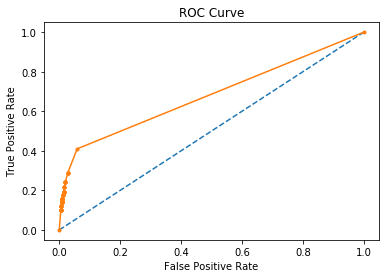

In [10]:
RF = RandomForestClassifier()
RF.fit(train_model_pred, train_response)
y_pred = RF.predict(test_model_pred)

model_eval(test_response, y_pred)

plot_roc_curve(RF, test_model_pred, test_response)

# cross_validation(RF, features, response, 5)

# print(sorted(zip(map(lambda x: round(x, 4), RF.feature_importances_), train_features.columns), 
#              reverse=True)[0:10])

## Stacked Logistic Regression (all features)

In [11]:
# logreg = LogisticRegression()

# logreg.fit(train_features, train_response)
# # y_pred = (logreg.predict_proba(test_features)[:,1] >= 0.3).astype(bool) #adjust classification threshold

# y_pred = logreg.predict(test_features)
# model_eval(test_response, y_pred)

# plot_roc_curve(logreg, test_features, test_response)

# # cross_validation(logreg, features, response, 5)

## Stacked Logistic Regression (just model prediction features)

In [12]:
logreg = LogisticRegression()

logreg.fit(train_model_pred, train_response)
y_pred = (logreg.predict_proba(test_model_pred)[:,1] >= 0.05).astype(bool) #adjust classification threshold

# y_pred = logreg.predict(test_model_pred)
model_eval(test_response, y_pred)

# plot_roc_curve(logreg, test_features, test_response)

# cross_validation(logreg, features, response, 5)



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,153914,5593
Order Success,5871,3053




               precision    recall  f1-score   support

   Order Fail       0.96      0.96      0.96    159507
Order Success       0.35      0.34      0.35      8924

  avg / total       0.93      0.93      0.93    168431



## Stacked Linear SVC

In [13]:
clf = svm.LinearSVC().fit(train_model_pred, train_response) #linear kernel function
y_pred = clf.predict(test_model_pred)
model_eval(test_response, y_pred)



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,156939,2568
Order Success,7042,1882




               precision    recall  f1-score   support

   Order Fail       0.96      0.98      0.97    159507
Order Success       0.42      0.21      0.28      8924

  avg / total       0.93      0.94      0.93    168431



## Neural Net (sklearn)

In [14]:
clfANN = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
           beta_1=0.95, beta_2=0.9995, early_stopping=False,
           epsilon=1e-05, hidden_layer_sizes=(100, 100),
           learning_rate='constant', learning_rate_init=0.01,
           max_iter=3000, momentum=0.9,
           nesterovs_momentum=True, power_t=0.5, random_state=0,
           shuffle=True, solver='adam', tol=0.001,
           validation_fraction=0.1, verbose=True, warm_start=False)


clfANN.fit(train_model_pred, train_response)
y_pred = (clfANN.predict_proba(test_model_pred)[:,1] >= 0.1).astype(bool) #adjust classification threshold

model_eval(test_response, y_pred)

Iteration 1, loss = 0.05116314
Iteration 2, loss = 0.03052808
Iteration 3, loss = 0.03057922
Iteration 4, loss = 0.03463943
Iteration 5, loss = 0.02732995
Iteration 6, loss = 0.02941921
Iteration 7, loss = 0.02510913
Iteration 8, loss = 0.02629122
Iteration 9, loss = 0.02660575
Iteration 10, loss = 0.02449621
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.


CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,155647,3860
Order Success,6469,2455




               precision    recall  f1-score   support

   Order Fail       0.96      0.98      0.97    159507
Order Success       0.39      0.28      0.32      8924

  avg / total       0.93      0.94      0.93    168431



## Neural Net (Keras)

In [15]:
# model = Sequential()
# model.add(Dense(100, input_dim=50, kernel_initializer='normal', activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# # model.summary()
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = model.fit(train_model_pred, train_response, epochs=5, batch_size=50, verbose=1, validation_split = 0.30)

# # "Loss"
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper right')
# plt.show()

In [16]:
# y_pred = (model.predict(test_model_pred >= 0.1)).astype(bool)
# model_eval(test_response, y_pred)